# GROUP PROJECT PROPOSAL

## Introduction:

Classification is the process in which data is grouped into classes based on their properties. K-nearest neighbour is a specific type of classification where an observation is classified based on the majority vote of its K amount of neighbours, (with K being predetermined via evaluations prior to actual testing to ensure maximum accuracy)  which allows us to predict a new set of data’s classes based on a known set of training data. In this project we will be experimenting with K-nearest neighbour classification hence this proposal will demonstrate a preliminary data analysis as well as provide context to how the process will be done and what we are expecting to discover.
	
Statistically speaking in sports (particularly racquet sports like badminton and tennis) left-handed players generally perform better, whether that be because their opponents are unfamiliar with playing against a lefty or they are simply more coordinated. There are numerous studies that support this theory, and we thought it would be interesting to see if there would be any correlation between a tennis player’s handedness, or more formally:

Is there a relationship between the handedness of a tennis player with their peak rank, current rank, height, age, and their backhand grip - i.e. can we derive the former by looking at their other attributes?

To answer our question we will be using the Tennis Player Stats for Top 500 Players.

## Preliminary Exploratory Data Analysis:


In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.plot.width = 12)
options(repr.matrix.max.rows = 6)

### Reading Data
The following code demonstrates that our dataset can be read from web into R

In [2]:
# tennis player data acquried from https://www.ultimatetennisstatistics.com/
url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "player_data.csv")

# player data with only the columns we want
player_data <- read_csv("player_data.csv")|> select(Age, Plays, `Current Rank`, `Best Rank`, Backhand, Height)
colnames(player_data) <- c("age", "handedness", "curr_rank", "best_rank", "backhand_grip", "height") 

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling, Tidying, and Cleaning Data
The steps below cleans up the data (removes the unecessary parts of each variable such as removing the birthdays after each players age, which is a cell that contains more than one value hence untidy) as well as splits the data into training and testing sets for classification.

In [12]:
# player data formatted - char fields converted to numerical and categorical fields converted to factors
player_data_formatted <- player_data |>
    mutate(age = as.numeric(sapply(strsplit(age," "), getElement, 1)), 
           curr_rank = as.numeric(sapply(strsplit(curr_rank," "), getElement, 1)), 
           best_rank = as.numeric(sapply(strsplit(best_rank," "), getElement, 1)),
           height = as.numeric(sapply(strsplit(height," "), getElement, 1)),
           backhand_grip = as_factor(backhand_grip),
           handedness = as_factor(handedness)
          )

# splitting data into training and testing sets
players_split <- initial_split(player_data_formatted, prop = 3/4, strata = handedness)
players_train <- training(players_split)
players_test <- testing(players_split)

players_train

age,handedness,curr_rank,best_rank,backhand_grip,height
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
18,Left-handed,326,316,Two-handed,NA
23,Left-handed,431,319,Two-handed,NA
30,Left-handed,123,75,Two-handed,NA
⋮,⋮,⋮,⋮,⋮,⋮
20,Right-handed,397,394,Two-handed,NA
20,Right-handed,382,380,Two-handed,NA
26,Right-handed,5,4,One-handed,185


### Summarize
The first summarization table allows us to see the distribution of the variable we're trying to predict - the handedness of a tennis player. The second table allows us to see how many variables we are missing for each of the predictors as well as the handedness of the players, this gives us an idea of which variable we should put more emphasis on (rank & age) and which to potentially discard (height).

In [16]:
# distribution of handedness among players
handedness_distribution <- players_train |>
    filter(!is.na(handedness)) |>
    group_by(handedness) |>
    summarize(count = n())

# count of the NA's of each variable
missing_variables <- players_train |>
    summarize(across(everything(), ~ sum(is.na(.))))

handedness_distribution
missing_variables

handedness,count
<fct>,<int>
Right-handed,292
Left-handed,44


age,handedness,curr_rank,best_rank,backhand_grip,height
<int>,<int>,<int>,<int>,<int>,<int>
1,38,3,1,75,291


### Visualization
The following plots allow us to visualize a preliminary relationship between our predictors with the handedness of a player.

`summarise()` has grouped output by 'handedness'. You can override using the
`.groups` argument.


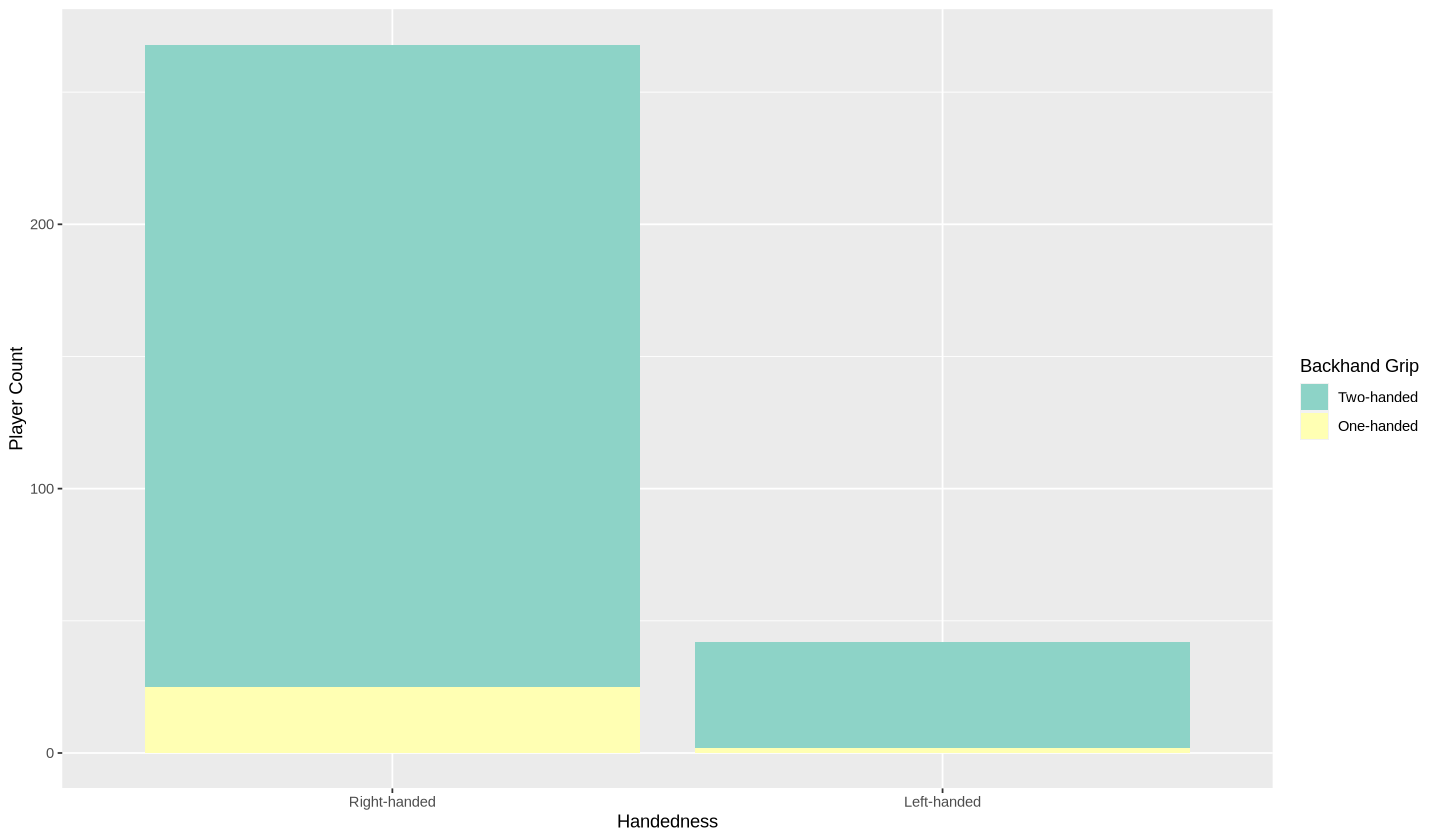

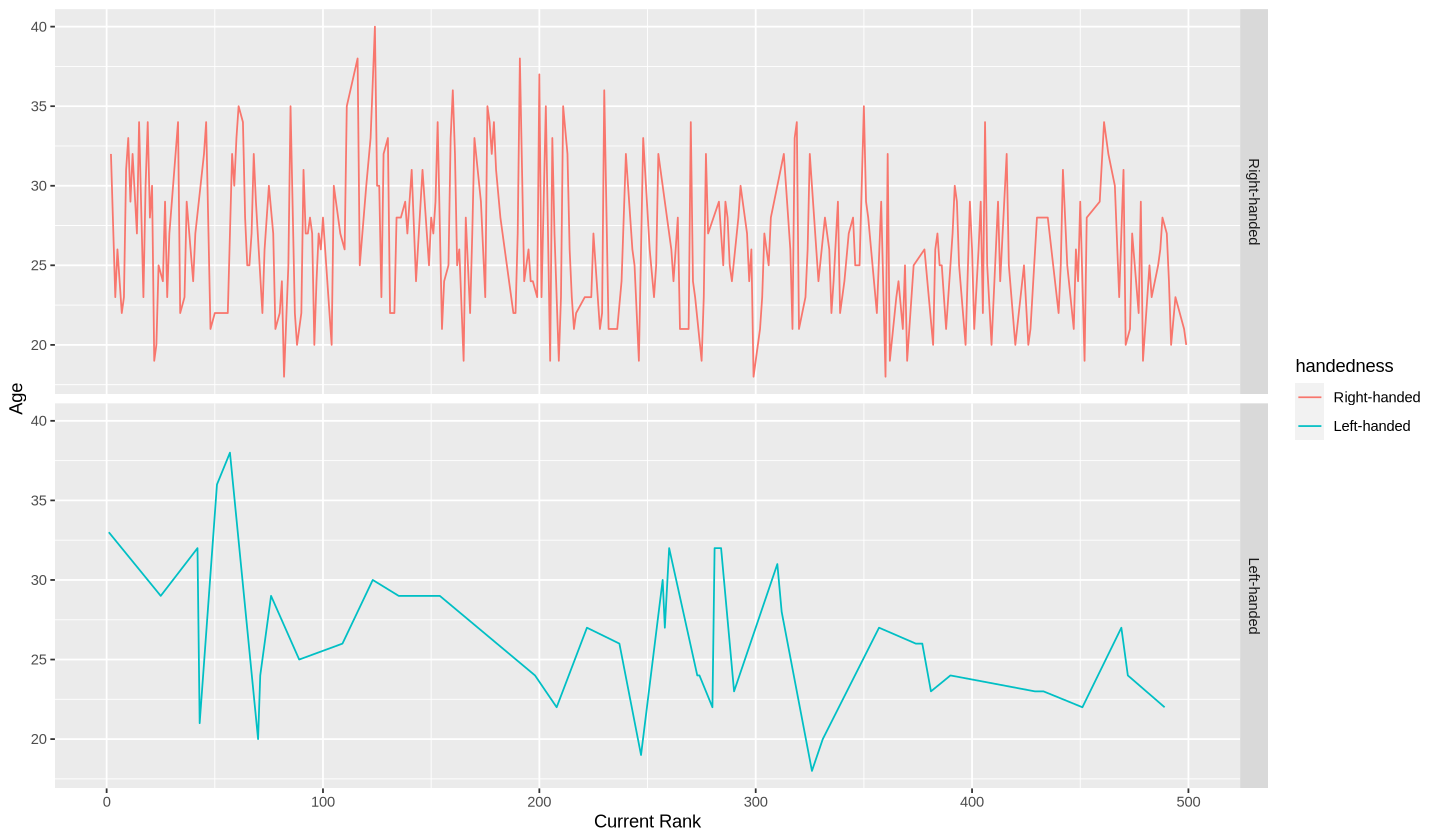

In [5]:
# visualizes the distribution of the handedness of players vs what their backhand grip is
handedness_backhand_distribution <- players_train |>
    filter(!is.na(handedness), !is.na(backhand_grip)) |>
    group_by(handedness, backhand_grip) |>
    summarize(count = n())

ggplot(handedness_backhand_distribution, aes(x = handedness, y = count, fill = backhand_grip)) + 
    geom_bar(stat = 'identity') +
    labs(x="Handedness", y = "Player Count", fill = "Backhand Grip") +
    scale_fill_brewer(palette = 'Set3')

# visualizes the distribution of age v.s. current rank of a player in respect to handedness
players_age_rank_handedness <- players_train |>
    filter(!is.na(handedness), !is.na(curr_rank), !is.na(age)) |>
    select(handedness, curr_rank, age)

ggplot(players_age_rank_handedness, aes(x = curr_rank, y = age, color = handedness)) +
    geom_line() +
    labs(x="Current Rank", y = "Age", fill = "Handedness") +
    facet_grid(rows = vars(handedness))

## Methods
We will be using the K-nearest neighbour algorithm to classify the handedness of a tennis player using these variables:
- Current rank to see how far they dropped in rankings with the hand they used to get there
- Peak rank to see how high each player went in rankings with the hand they used to get there
- Height to see if the height of the player affects the hand they use
- Age to see if the age of the player affects the hand they use
- Backhand grip to see if more players use a one-handed backhand grip or a two-handed backhand grip with the specific hand they use
  
We have omitted:
- Country
- Name
- Prize money
- Turned pro
- Season

None of these variables are physical attributes of the player and we believe they would have no effect / are not directly affected by the handedness of a player.


Having multiple predictors, we have the opportunity to plot the handedness of a player against a multitude of their other attributes. An example could be the players' preference for backhand grip v.s. their dominant hand, which we have done for this proposal's preliminary data analysis.